# CNN model training for all LAQN stations

This notebook trains convolutional neural network (CNN) models to predict air pollution levels across ALL London Air Quality Network stations. I train CNN models for every station pollutant combination in the LAQN dataset.

the goal is to compare network wide CNN performance against the random forest results from rf_training_laqn_all.ipynb.

## Why all stations instead of one?

The single station approach (EN5_NO2) was useful for proof of concept. The dissertation needs to show how the models perform across the entire LAQN network. This means training separate models for each of the 141 station pollutant combinations.


## Structure of notebook:

| section | what it does                                |
| ------- | ------------------------------------------- |
| 1       | Setup and Imports                           |
| 2       | Load Prepared Data `ml_prep_all`            |
| 3       | Understanding Data Shapes                   |
| 4       | Identify All Target Columns                 |
| 5       | Build CNN Model Function                    |
| 6       | Set-up Training Callbacks                   |
| 7       | Train Models For All Targets with Callbacks |
| 8       | Load Results Colab Training Output          |
| 9       | Investigation of Broken Models              |
| 10      | Baseline Evaluation After Exclusion         |
| 11      | Results Summary and Aave                    |
| 12      | Prediction Visualisations                   |
| 13      | Residual Analysis                           |
| 14      | Final Summary                               |

## 

## 1) Setup and Imports

Importing everything needed for CNN training. tensorflow/keras handles the neural network numpy for arrays matplotlib and seaborn for plotting scikit learn for metrics.

In [1]:
#Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
import time
import gc
from collections import Counter
warnings.filterwarnings('ignore')

#Scikit learn for metrics r2, MSE, MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Tensorflow and keras for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.16.2


tensorflow version: 2.19.0

In [2]:
#paths
base_dir = Path.cwd().parent.parent / 'data' / 'laqn'
data_dir = base_dir / 'ml_prep_all'
output_dir = Path.cwd().parent.parent / 'data' / 'ml' / 'LAQN_all' / 'cnn_model'
output_dir.mkdir(parents=True, exist_ok=True)

print(f'loading data from: {data_dir}')
print(f'saving outputs to: {output_dir}')

loading data from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/ml_prep_all
saving outputs to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/LAQN_all/cnn_model


### GPU availability

checking if GPU is available. CNN training is faster on GPU but will still work on CPU.

source: Use a GPU: Tensorflow Core (no date) TensorFlow. Available at: https://www.tensorflow.org/guide/gpu

In [3]:
#Check gpu availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'GPU available: {len(gpus)} device(s)')
    for gpu in gpus:
        print(f'  - {gpu.name}')
else:
    print('No GPU found, using CPU training will be slower but still works.')

No GPU found, using CPU training will be slower but still works.


no GPU found, using CPU training will be slower but still works


## 2) Load Prepared Data `ml_prep_all`

The data was prepared in `ml_prep_laqn_all.ipynb`it created sequences where each sample has 12 hours of history to predict the next hour for all stations.

### why 3D data for CNN?

Random forest needs flat 2D data: (samples, features). CNN needs 3D data: (samples, timesteps, features). the 3D shape lets CNN learn patterns across time, not just treat each timestep as an independent feature.


| Data Shape | Model | Structure |
|------------|-------|----------|
| 2D | random forest | each row is a flat list of numbers with no structure |
| 3D | CNN | each sample is a grid where rows are hours and columns are features |

In [4]:
#Load the 3d sequences for cnn
X_train = np.load(data_dir / 'X_train.npy')
X_val = np.load(data_dir / 'X_val.npy')
X_test = np.load(data_dir / 'X_test.npy')

y_train = np.load(data_dir / 'y_train.npy')
y_val = np.load(data_dir / 'y_val.npy')
y_test = np.load(data_dir / 'y_test.npy')

#Load feature_names and scaler
feature_names = joblib.load(data_dir / 'feature_names.joblib')
scaler = joblib.load(data_dir / 'scaler.joblib')

print('Data loaded successfully.')
print(f'\nShapes:')
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val: {y_val.shape}')
print(f'y_test: {y_test.shape}')

Data loaded successfully.

Shapes:
X_train: (17107, 12, 145)
X_val: (3656, 12, 145)
X_test: (3657, 12, 145)
y_train: (17107, 145)
y_val: (3656, 145)
y_test: (3657, 145)


    data loaded successfully

    shapes:
    X_train: (17107, 12, 145)
    X_val: (3656, 12, 145)
    X_test: (3657, 12, 145)
    y_train: (17107, 145)
    y_val: (3656, 145)
    y_test: (3657, 145)

## 3) Understanding Data Shapes

X_train shape:

| Dimension | What it represents |
|-----------|--------------|
| first | number of samples (individual training examples) |
| second | timesteps (12 hours of history) |
| third | features (all station pollutant columnS +temporal) |

y_train shape is (samples, features). The model can predict all features for the next hour.

In [5]:
#Extract dimensions
n_samples, timesteps, n_features = X_train.shape

print(f'\ndata dimensions:')
print(f'  samples: {n_samples:,}')
print(f'  timesteps: {timesteps}')
print(f'  features: {n_features}')
print(f'\nfeature names ({len(feature_names)} total):')
print(f'  first 10: {feature_names[:10]}')
print(f'  last 10: {feature_names[-10:]}')


data dimensions:
  samples: 17,107
  timesteps: 12
  features: 145

feature names (145 total):
  first 10: ['BG1_NO2', 'BG1_SO2', 'BG2_NO2', 'BG2_PM10', 'BQ7_NO2', 'BQ7_O3', 'BQ7_PM10', 'BQ7_PM25', 'BQ9_PM10', 'BQ9_PM25']
  last 10: ['WAC_PM10', 'WM5_NO2', 'WM6_NO2', 'WM6_PM10', 'WMD_NO2', 'WMD_PM25', 'hour', 'day_of_week', 'month', 'is_weekend']


  data dimensions:
  samples: 17,107
  timesteps: 12
  features: 145

  feature names (145 total):
    first 10: ['BG1_NO2', 'BG1_SO2', 'BG2_NO2', 'BG2_PM10', 'BQ7_NO2', 'BQ7_O3', 'BQ7_PM10', 'BQ7_PM25', 'BQ9_PM10', 'BQ9_PM25']
    last 10: ['WAC_PM10', 'WM5_NO2', 'WM6_NO2', 'WM6_PM10', 'WMD_NO2', 'WMD_PM25', 'hour', 'day_of_week', 'month', 'is_weekend']

## 4) Identify All Target Columns

Need to identify which columns are pollutant predictions (targets) and which are temporal features. Temporal features like hour, day_of_week are inputs only, not things we want to predict.

### Pollutant Naming Convention

Each target column follows the pattern: `{SiteCode}_{PollutantCode}`

Example:

| Example | Meaning |
|---------|--------|
| BG1_NO2 | NO2 at site BG1 |
| EN5_PM25 | PM2.5 at site EN5 |

### The 6 regulatory pollutants:

| Pollutant | Code | UK Annual Limit |
|-----------|------|----------------|
| Nitrogen Dioxide | NO2 | 40 ug/m3 |
| PM2.5 Particulate | PM25 | 20 ug/m3 |
| PM10 Particulate | PM10 | 40 ug/m3 |
| Ozone | O3 | n/a |
| Sulphur Dioxide | SO2 | n/a |
| Carbon Monoxide | CO | n/a |


In [6]:
#Temporal vs pollutant columns
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']

#Get pollutant target columns everything except temporal
target_names = [name for name in feature_names if name not in temporal_cols]
target_indices = [i for i, name in enumerate(feature_names) if name not in temporal_cols]

#Create target mapping dictionary
target_mapping = {name: i for i, name in enumerate(feature_names) if name not in temporal_cols}

print(f'total features: {len(feature_names)}')
print(f'temporal features: {len(temporal_cols)}')
print(f'pollutant targets: {len(target_names)}')

#Count by pollutant type
pollutant_codes = ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']
print(f'\nbreakdown by pollutant:')
for poll in pollutant_codes:
    count = len([n for n in target_names if f'_{poll}' in n])
    print(f'  {poll}: {count} stations')

total features: 145
temporal features: 4
pollutant targets: 141

breakdown by pollutant:
  NO2: 58 stations
  PM25: 24 stations
  PM10: 42 stations
  O3: 11 stations
  SO2: 4 stations
  CO: 2 stations


    total features: 145
    temporal features: 4
    pollutant targets: 141

    breakdown by pollutant:
      NO2: 58 stations
      PM25: 24 stations
      PM10: 42 stations
      O3: 11 stations
      SO2: 4 stations
      CO: 2 stations


In [7]:
#Prepare y arrays with only pollutant targets excluded temporal
y_train_targets = y_train[:, target_indices]
y_val_targets = y_val[:, target_indices]
y_test_targets = y_test[:, target_indices]

print(f'target arrays prepared:')
print(f'  y_train_targets: {y_train_targets.shape}')
print(f'  y_val_targets: {y_val_targets.shape}')
print(f'  y_test_targets: {y_test_targets.shape}')
print(f'\nwill train {len(target_names)} separate CNN models')

target arrays prepared:
  y_train_targets: (17107, 141)
  y_val_targets: (3656, 141)
  y_test_targets: (3657, 141)

will train 141 separate CNN models


    target arrays prepared:
      y_train_targets: (17107, 141)
      y_val_targets: (3656, 141)
      y_test_targets: (3657, 141)

    will train 141 separate CNN models


## 5)Build CNN Model Function

Building a function that creates CNN models. Using the best hyperparameters found from the single station tuning:

| parameter | value | why |
|-----------|-------|-----|
| filters_1 | 128 | more capacity to learn patterns |
| kernel_1 | 2 | short term patterns matter most |
| dropout | 0.1 | less regularisation needed |
| filters_2 | 64 | second layer with fewer filters |
| kernel_2 | 2 | consistent with first layer |
| dense_units | 50 | same as baseline |
| learning_rate | 0.001 | adam default works well |

These parameters came from keras tuner results in the single station CNN notebook.

source: Geron, A. (2023) Hands on machine learning with scikit learn, Keras and TensorFlow. Ch. 15.

In [8]:
def build_cnn_model(timesteps,
                    features, filters_1=128,
                    filters_2=64,
                    kernel_size=2,
                    dropout_rate=0.1,
                    dense_units=50,
                    learning_rate=0.001):
    """
    Build a 1D CNN for time series prediction.
    Based on tuned hyperparameters from single station experiment.

    params:
        timesteps: number of historical hours (12)
        features: number of input features
        filters_1: filters in first conv layer
        filters_2: filters in second conv layer
        kernel_size: size of convolutional kernel
        dropout_rate: dropout rate for regularisation
        dense_units: neurons in dense layer
        learning_rate: adam learning rate

    returns:
        compiled keras model
    """
    model = models.Sequential([
        #Input layer
        layers.Input(shape=(timesteps, features)),

        #first conv layer
        layers.Conv1D(
            filters=filters_1,
            kernel_size=kernel_size,
            activation='relu',
            padding='causal'
        ),
        layers.Dropout(dropout_rate),

        #2. conv layer
        layers.Conv1D(
            filters=filters_2,
            kernel_size=kernel_size,
            activation='relu',
            padding='causal'
        ),
        layers.Dropout(dropout_rate),

        #Flatten and dense
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),

        #Output layer single value
        layers.Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='mse',
        metrics=['mae']
    )

    return model

In [9]:
#Test model creation
test_model = build_cnn_model(timesteps, n_features)
print(f'model created with {test_model.count_params():,} parameters')
test_model.summary()

model created with 92,197 parameters


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 12, 128)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        38,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,197 (360.14 KB)

 Trainable params: 92,197 (360.14 KB)

 Non-trainable params: 0 (0.00 B)

    model created with 92,197 parameters
    Model: "sequential"

    ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
    ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
    ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
    │ conv1d (Conv1D)                 │ (None, 12, 128)        │        37,248 │
    ├─────────────────────────────────┼────────────────────────┼───────────────┤
    │ dropout (Dropout)               │ (None, 12, 128)        │             0 │
    ├─────────────────────────────────┼────────────────────────┼───────────────┤
    │ conv1d_1 (Conv1D)               │ (None, 12, 64)         │        16,448 │
    ├─────────────────────────────────┼────────────────────────┼───────────────┤
    │ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
    ├─────────────────────────────────┼────────────────────────┼───────────────┤
    │ flatten (Flatten)               │ (None, 768)            │             0 │
    ├─────────────────────────────────┼────────────────────────┼───────────────┤
    │ dense (Dense)                   │ (None, 50)             │        38,450 │
    ├─────────────────────────────────┼────────────────────────┼───────────────┤
    │ dropout_2 (Dropout)             │ (None, 50)             │             0 │
    ├─────────────────────────────────┼────────────────────────┼───────────────┤
    │ dense_1 (Dense)                 │ (None, 1)              │            51 │
    └─────────────────────────────────┴────────────────────────┴───────────────┘

    Total params: 92,197 (360.14 KB)

    Trainable params: 92,197 (360.14 KB)

    Non-trainable params: 0 (0.00 B)



### understanding the summary

the summary shows each layer, its output shape, and parameter count.

| term | meaning |
|------|--------|
| param # | number of learnable weights. more parameters = more capacity to learn, but also more risk of overfitting |
| output shape | (None, timesteps, filters). None is batch size, determined at runtime |
| total params | all weights the model will learn during training |

the model has 92,197 parameters which is appropriate for this task.

## 6)Set-up Training Callbacks

Callbacks control training behaviour.

| Callback | What it does | Why |
|----------|--------------|-----|
| EarlyStopping | stops when validation loss stops improving | prevents overfitting |
| ReduceLROnPlateau | reduces learning rate when stuck | helps find better minimum |

Not using ModelCheckpoint for each model because of 141 targets. Saving checkpoints manually every N models instead.

source: Team, K. (no date) Keras Documentation: Callbacks. Available at: https://keras.io/api/callbacks/

In [10]:
def get_callbacks():
    """Create callbacks for training."""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=0
        )
    ]

print('Callbacks configured:')
print('Early stopping (patience=10)')
print('Reduce LR on plateau (factor=0.5, patience=5)')

Callbacks configured:
Early stopping (patience=10)
Reduce LR on plateau (factor=0.5, patience=5)


  callbacks configured:
    - early stopping (patience=10)
    - reduce LR on plateau (factor=0.5, patience=5)


## 7) Train Models For All Targets

Training a separate CNN model for each target. This will take a while because:

| aspect | detail |
|--------|--------|
| targets | 141 station pollutant combinations |
| epochs per model | up to 50 (early stopping) |


### Checkpoint

Saving results every 20 models in case something goes wrong(Since I ran this notebook on Colab this clever approach not work). this way if the notebook crashes, I don't lose everything.


source: Geron, A. (2023) Hands on machine learning with scikit learn, Keras and TensorFlow. Ch. 11.

**note:** Training was completed on Google Colab. The results are loaded in section 8 manually extracted from the output of it.

In [11]:
#Training configuration
BATCH_SIZE = 32
MAX_EPOCHS = 50
CHECKPOINT_EVERY = 20

print(f'training configuration:')
print(f'  batch size: {BATCH_SIZE}')
print(f'  max epochs: {MAX_EPOCHS}')
print(f'  checkpoint every: {CHECKPOINT_EVERY} models')
print(f'  total targets: {len(target_names)}')

training configuration:
  batch size: 32
  max epochs: 50
  checkpoint every: 20 models
  total targets: 141


  training configuration:
    batch size: 32
    max epochs: 50
    checkpoint every: 20 models
    total targets: 141

### Training Loop as Reference Only

The training loop below was run on Google Colab and took 5.74 hours to complete. The results are loaded from the output logs in the next section.

In [12]:
#Training loop reference code
results = []
all_models = {}

start_time = time.time()

print(f'Started at: {time.strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Targets to train: {len(target_names)}')
print(f'Training samples: {n_samples:,}')
print(f'Features: {n_features}')
print('=' * 40)

for i, target_name in enumerate(target_names):
    target_idx = target_mapping[target_name]
    model_start = time.time()

    #Build model
    model = build_cnn_model(timesteps, n_features)

    #Train
    history = model.fit(
        X_train, y_train[:, target_idx],
        validation_data=(X_val, y_val[:, target_idx]),
        epochs=MAX_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=get_callbacks(),
        verbose=0
    )

    #Evaluate on test set
    y_pred = model.predict(X_test, verbose=0).flatten()
    y_actual = y_test[:, target_idx]

    test_r2 = r2_score(y_actual, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    test_mae = mean_absolute_error(y_actual, y_pred)

    #Extract pollutant from target name
    parts = target_name.rsplit('_', 1)
    pollutant = parts[1] if len(parts) > 1 else 'unknown'

    results.append({
        'target': target_name,
        'pollutant': pollutant,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'epochs': len(history.history['loss'])
    })

    #store model
    all_models[target_name] = model

    #progress update
    elapsed = time.time() - model_start
    remaining = len(target_names) - (i + 1)
    eta = (elapsed * remaining) / 60
    print(f'[{i+1:3d}/{len(target_names)}] {target_name:15s} | R2={test_r2:.3f} | Time={elapsed:.0f}s | ETA={eta:.0f}min')

    #checkpoint
    if (i + 1) % CHECKPOINT_EVERY == 0:
        checkpoint_df = pd.DataFrame(results)
        checkpoint_df.to_csv(output_dir / f'checkpoint_{i+1}.csv', index=False)
        print(f'   [Checkpoint saved at {i+1} models]')

    #memory cleanup
    tf.keras.backend.clear_session()
    gc.collect()

total_time = (time.time() - start_time) / 60
print('=' * 40)
print('Training complete!')
print(f'Total time: {total_time:.1f} minutes ({total_time/60:.2f} hours)')
print(f'Average per model: {total_time*60/len(target_names):.1f} seconds')


Started at: 2026-01-02 20:31:32
Targets to train: 141
Training samples: 17,107
Features: 145
[  1/141] BG1_NO2         | R2=0.452 | Time=44s | ETA=102min
[  2/141] BG1_SO2         | R2=0.786 | Time=36s | ETA=84min
[  3/141] BG2_NO2         | R2=-1933365622256684998919666532352.000 | Time=46s | ETA=107min
[  4/141] BG2_PM10        | R2=0.032 | Time=21s | ETA=47min
[  5/141] BQ7_NO2         | R2=0.685 | Time=32s | ETA=73min
[  6/141] BQ7_O3          | R2=0.911 | Time=49s | ETA=111min
[  7/141] BQ7_PM10        | R2=0.769 | Time=37s | ETA=83min
[  8/141] BQ7_PM25        | R2=0.786 | Time=41s | ETA=91min
[  9/141] BQ9_PM10        | R2=0.764 | Time=57s | ETA=125min
[ 10/141] BQ9_PM25        | R2=0.760 | Time=48s | ETA=105min
[ 11/141] BT4_NO2         | R2=0.796 | Time=40s | ETA=86min
[ 12/141] BT4_PM10        | R2=0.522 | Time=49s | ETA=105min
[ 13/141] BT4_PM25        | R2=0.494 | Time=44s | ETA=93min
[ 14/141] BT5_NO2         | R2=0.726 | Time=41s | ETA=86min
[ 15/141] BT5_PM10        | R2

    Started at: 2026-01-02 20:31:32
    Targets to train: 141
    Training samples: 17,107
    Features: 145
    ========================================
    [  1/141] BG1_NO2         | R2=0.452 | Time=44s | ETA=102min
    [  2/141] BG1_SO2         | R2=0.786 | Time=36s | ETA=84min
    [  3/141] BG2_NO2         | R2=-1933365622256684998919666532352.000 | Time=46s | ETA=107min
    [  4/141] BG2_PM10        | R2=0.032 | Time=21s | ETA=47min
    [  5/141] BQ7_NO2         | R2=0.685 | Time=32s | ETA=73min
    [  6/141] BQ7_O3          | R2=0.911 | Time=49s | ETA=111min
    [  7/141] BQ7_PM10        | R2=0.769 | Time=37s | ETA=83min
    [  8/141] BQ7_PM25        | R2=0.786 | Time=41s | ETA=91min
    [  9/141] BQ9_PM10        | R2=0.764 | Time=57s | ETA=125min
    [ 10/141] BQ9_PM25        | R2=0.760 | Time=48s | ETA=105min
    [ 11/141] BT4_NO2         | R2=0.796 | Time=40s | ETA=86min
    [ 12/141] BT4_PM10        | R2=0.522 | Time=49s | ETA=105min
    [ 13/141] BT4_PM25        | R2=0.494 | Time=44s | ETA=93min
    [ 14/141] BT5_NO2         | R2=0.726 | Time=41s | ETA=86min
    [ 15/141] BT5_PM10        | R2=0.516 | Time=25s | ETA=53min
    [ 16/141] BT5_PM25        | R2=0.152 | Time=47s | ETA=98min
    [ 17/141] BT6_NO2         | R2=0.782 | Time=55s | ETA=114min
    [ 18/141] BT6_PM10        | R2=0.464 | Time=25s | ETA=51min
    [ 19/141] BT6_PM25        | R2=0.484 | Time=41s | ETA=84min
    [ 20/141] BT8_NO2         | R2=0.732 | Time=32s | ETA=65min
      [Checkpoint saved at 20 models]
    [ 21/141] BT8_PM10        | R2=0.535 | Time=32s | ETA=64min
    [ 22/141] BT8_PM25        | R2=0.558 | Time=42s | ETA=83min
    [ 23/141] BX1_NO2         | R2=0.776 | Time=45s | ETA=89min
    [ 24/141] BX1_O3          | R2=0.905 | Time=57s | ETA=112min
    [ 25/141] BX1_SO2         | R2=0.605 | Time=54s | ETA=105min
    [ 26/141] BX2_NO2         | R2=0.763 | Time=43s | ETA=82min
    [ 27/141] BX2_PM10        | R2=0.535 | Time=32s | ETA=61min
    [ 28/141] BX2_PM25        | R2=0.759 | Time=28s | ETA=53min
    [ 29/141] BY7_NO2         | R2=0.729 | Time=30s | ETA=56min
    [ 30/141] BY7_PM10        | R2=0.495 | Time=50s | ETA=92min
    [ 31/141] BY7_PM25        | R2=0.485 | Time=29s | ETA=54min
    [ 32/141] CD1_NO2         | R2=0.688 | Time=28s | ETA=51min
    [ 33/141] CD1_PM10        | R2=0.590 | Time=33s | ETA=60min
    [ 34/141] CD1_PM25        | R2=0.490 | Time=25s | ETA=44min
    [ 35/141] CE2_NO2         | R2=0.688 | Time=27s | ETA=48min
    [ 36/141] CE2_O3          | R2=0.890 | Time=97s | ETA=170min
    [ 37/141] CE2_PM10        | R2=0.376 | Time=16s | ETA=27min
    [ 38/141] CE2_PM25        | R2=0.741 | Time=35s | ETA=60min
    [ 39/141] CE3_NO2         | R2=0.610 | Time=31s | ETA=53min
    [ 40/141] CE3_PM10        | R2=0.478 | Time=30s | ETA=50min
      [Checkpoint saved at 40 models]
    [ 41/141] CE3_PM25        | R2=0.523 | Time=44s | ETA=74min
    [ 42/141] CR5_NO2         | R2=0.826 | Time=38s | ETA=62min
    [ 43/141] CR7_NO2         | R2=0.791 | Time=51s | ETA=83min
    [ 44/141] CR8_PM25        | R2=0.000 | Time=44s | ETA=71min
    [ 45/141] CW3_NO2         | R2=0.729 | Time=27s | ETA=44min
    [ 46/141] CW3_PM10        | R2=0.843 | Time=36s | ETA=58min
    [ 47/141] CW3_PM25        | R2=0.876 | Time=59s | ETA=92min
    [ 48/141] EA6_NO2         | R2=0.789 | Time=57s | ETA=88min
    [ 49/141] EA6_PM10        | R2=0.517 | Time=30s | ETA=46min
    [ 50/141] EA8_NO2         | R2=0.789 | Time=41s | ETA=63min
    [ 51/141] EA8_PM10        | R2=0.616 | Time=33s | ETA=50min
    [ 52/141] EI1_NO2         | R2=0.817 | Time=34s | ETA=51min
    [ 53/141] EI1_PM10        | R2=0.479 | Time=31s | ETA=45min
    [ 54/141] EI8_PM10        | R2=0.586 | Time=26s | ETA=38min
    [ 55/141] EN1_NO2         | R2=0.862 | Time=49s | ETA=71min
    [ 56/141] EN4_NO2         | R2=0.710 | Time=21s | ETA=29min
    [ 57/141] EN5_NO2         | R2=0.808 | Time=37s | ETA=51min
    [ 58/141] EN7_NO2         | R2=0.730 | Time=25s | ETA=35min
    [ 59/141] GB0_PM25        | R2=0.580 | Time=29s | ETA=39min
    [ 60/141] GB6_NO2         | R2=0.831 | Time=47s | ETA=64min
      [Checkpoint saved at 60 models]
    [ 61/141] GB6_O3          | R2=0.912 | Time=43s | ETA=57min
    [ 62/141] GB6_PM10        | R2=0.506 | Time=43s | ETA=57min
    [ 63/141] GN0_NO2         | R2=0.813 | Time=34s | ETA=44min
    [ 64/141] GN0_PM10        | R2=0.502 | Time=41s | ETA=53min
    [ 65/141] GN0_PM25        | R2=0.589 | Time=31s | ETA=39min
    [ 66/141] GN3_NO2         | R2=0.789 | Time=40s | ETA=50min
    [ 67/141] GN3_O3          | R2=0.878 | Time=42s | ETA=52min
    [ 68/141] GN3_PM10        | R2=0.484 | Time=30s | ETA=36min
    [ 69/141] GN3_PM25        | R2=0.691 | Time=32s | ETA=38min
    [ 70/141] GN4_NO2         | R2=0.814 | Time=35s | ETA=42min
    [ 71/141] GN4_PM10        | R2=0.563 | Time=49s | ETA=57min
    [ 72/141] GN5_NO2         | R2=0.758 | Time=30s | ETA=35min
    [ 73/141] GN5_PM10        | R2=0.548 | Time=28s | ETA=31min
    [ 74/141] GN6_NO2         | R2=0.751 | Time=37s | ETA=41min
    [ 75/141] GN6_PM10        | R2=0.620 | Time=24s | ETA=26min
    [ 76/141] GN6_PM25        | R2=-0.457 | Time=36s | ETA=39min
    [ 77/141] GR7_NO2         | R2=0.749 | Time=57s | ETA=61min
    [ 78/141] GR7_PM10        | R2=0.619 | Time=35s | ETA=37min
    [ 79/141] GR8_NO2         | R2=0.739 | Time=35s | ETA=37min
    [ 80/141] GR8_PM10        | R2=0.551 | Time=33s | ETA=34min
      [Checkpoint saved at 80 models]
    [ 81/141] GR9_NO2         | R2=0.840 | Time=55s | ETA=55min
    [ 82/141] GR9_PM10        | R2=0.580 | Time=38s | ETA=38min
    [ 83/141] GR9_PM25        | R2=0.474 | Time=45s | ETA=43min
    [ 84/141] HG1_NO2         | R2=0.747 | Time=41s | ETA=39min
    [ 85/141] HG4_NO2         | R2=0.860 | Time=43s | ETA=41min
    [ 86/141] HG4_O3          | R2=0.903 | Time=41s | ETA=38min
    [ 87/141] HP1_NO2         | R2=0.782 | Time=25s | ETA=23min
    [ 88/141] HP1_O3          | R2=0.887 | Time=30s | ETA=27min
    [ 89/141] HP1_PM10        | R2=0.785 | Time=42s | ETA=37min
    [ 90/141] HP1_PM25        | R2=0.855 | Time=50s | ETA=43min
    [ 91/141] HV1_NO2         | R2=0.787 | Time=33s | ETA=28min
    [ 92/141] HV3_NO2         | R2=0.716 | Time=42s | ETA=35min
    [ 93/141] HV3_PM10        | R2=0.780 | Time=53s | ETA=42min
    [ 94/141] IS2_NO2         | R2=0.711 | Time=45s | ETA=35min
    [ 95/141] IS2_PM10        | R2=0.173 | Time=30s | ETA=23min
    [ 96/141] IS6_NO2         | R2=0.755 | Time=52s | ETA=39min
    [ 97/141] IS6_PM10        | R2=0.304 | Time=59s | ETA=43min
    [ 98/141] KC1_CO          | R2=0.757 | Time=37s | ETA=26min
    [ 99/141] KC1_NO2         | R2=0.839 | Time=37s | ETA=26min
    [100/141] KC1_O3          | R2=0.822 | Time=22s | ETA=15min
      [Checkpoint saved at 100 models]
    [101/141] KC1_PM25        | R2=0.824 | Time=35s | ETA=24min
    [102/141] KC1_SO2         | R2=0.804 | Time=44s | ETA=29min
    [103/141] LB4_NO2         | R2=0.539 | Time=36s | ETA=23min
    [104/141] LB4_PM10        | R2=0.471 | Time=37s | ETA=23min
    [105/141] LB4_PM25        | R2=0.419 | Time=38s | ETA=23min
    [106/141] LB6_NO2         | R2=0.839 | Time=35s | ETA=20min
    [107/141] LB6_PM10        | R2=0.338 | Time=29s | ETA=17min
    [108/141] ME9_NO2         | R2=0.768 | Time=41s | ETA=22min
    [109/141] MY1_CO          | R2=0.816 | Time=47s | ETA=25min
    [110/141] MY1_NO2         | R2=0.731 | Time=32s | ETA=16min
    [111/141] MY1_O3          | R2=0.867 | Time=31s | ETA=15min
    [112/141] MY1_SO2         | R2=-0.180 | Time=59s | ETA=28min
    [113/141] RI1_NO2         | R2=0.753 | Time=38s | ETA=18min
    [114/141] RI1_PM10        | R2=0.409 | Time=28s | ETA=13min
    [115/141] RI2_NO2         | R2=0.813 | Time=49s | ETA=21min
    [116/141] RI2_O3          | R2=0.891 | Time=36s | ETA=15min
    [117/141] RI2_PM10        | R2=0.520 | Time=31s | ETA=13min
    [118/141] SK5_NO2         | R2=0.812 | Time=51s | ETA=20min
    [119/141] SK5_PM10        | R2=0.631 | Time=35s | ETA=13min
    [120/141] TH2_NO2         | R2=0.784 | Time=27s | ETA=9min
      [Checkpoint saved at 120 models]
    [121/141] TH4_NO2         | R2=-220288011839820783271215628288.000 | Time=41s | ETA=14min
    [122/141] TH4_O3          | R2=-767707728500310840377834733568.000 | Time=54s | ETA=17min
    [123/141] TH4_PM10        | R2=-1091547997883440133859849535488.000 | Time=37s | ETA=11min
    [124/141] TH4_PM25        | R2=0.000 | Time=60s | ETA=17min
    [125/141] TL4_NO2         | R2=0.641 | Time=39s | ETA=11min
    [126/141] TL5_NO2         | R2=0.521 | Time=38s | ETA=10min
    [127/141] TL6_NO2         | R2=0.688 | Time=32s | ETA=8min
    [128/141] TL6_PM25        | R2=0.198 | Time=16s | ETA=4min
    [129/141] WA7_NO2         | R2=0.386 | Time=28s | ETA=6min
    [130/141] WA7_PM10        | R2=0.449 | Time=38s | ETA=7min
    [131/141] WA9_PM10        | R2=0.600 | Time=59s | ETA=10min
    [132/141] WAA_NO2         | R2=0.674 | Time=44s | ETA=7min
    [133/141] WAA_PM10        | R2=0.388 | Time=16s | ETA=2min
    [134/141] WAB_NO2         | R2=0.831 | Time=26s | ETA=3min
    [135/141] WAB_PM10        | R2=0.340 | Time=30s | ETA=3min
    [136/141] WAC_PM10        | R2=0.502 | Time=38s | ETA=3min
    [137/141] WM5_NO2         | R2=0.785 | Time=36s | ETA=2min
    [138/141] WM6_NO2         | R2=0.612 | Time=35s | ETA=2min
    [139/141] WM6_PM10        | R2=-16559508437584795035104182272.000 | Time=30s | ETA=1min
    [140/141] WMD_NO2         | R2=0.583 | Time=208s | ETA=3min
      [Checkpoint saved at 140 models]
    [141/141] WMD_PM25        | R2=0.670 | Time=36s | ETA=0min
    ========================================
    Training complete!
    Total time: 95.3 minutes (1.59 hours)
    Average per model: 40.5 seconds

In [25]:
#Save models and results after training completes
joblib.dump(all_models, output_dir / 'cnn_all_models.joblib')
print(f'saved {len(all_models)} models')

saved 141 models


## 8) Load Results Colab Training Output

The training was completed on Google Colab on 31 December 2025. the results below are extracted from the training output logs, manually added.

total training time: 344.7 minutes (5.74 hours)

average time per model: 146.7 seconds

In [13]:
# #Results extracted from colab output manually format target_name, test_r2
# colab_results = [
#     ('BG1_NO2', 0.585),
#     ('BG1_SO2', 0.656),
#     ('BG2_NO2', -1.496e+30),
#     ('BG2_PM10', 0.023),
#     ('BQ7_NO2', 0.706),
#     ('BQ7_O3', 0.910),
#     ('BQ7_PM10', 0.760),
#     ('BQ7_PM25', 0.758),
#     ('BQ9_PM10', 0.730),
#     ('BQ9_PM25', 0.726),
#     ('BT4_NO2', 0.804),
#     ('BT4_PM10', 0.554),
#     ('BT4_PM25', 0.522),
#     ('BT5_NO2', 0.747),
#     ('BT5_PM10', 0.525),
#     ('BT5_PM25', 0.164),
#     ('BT6_NO2', 0.784),
#     ('BT6_PM10', 0.507),
#     ('BT6_PM25', 0.463),
#     ('BT8_NO2', 0.729),
#     ('BT8_PM10', 0.551),
#     ('BT8_PM25', 0.579),
#     ('BX1_NO2', 0.788),
#     ('BX1_O3', 0.891),
#     ('BX1_SO2', 0.701),
#     ('BX2_NO2', 0.761),
#     ('BX2_PM10', 0.554),
#     ('BX2_PM25', 0.777),
#     ('BY7_NO2', 0.722),
#     ('BY7_PM10', 0.416),
#     ('BY7_PM25', 0.462),
#     ('CD1_NO2', 0.682),
#     ('CD1_PM10', 0.554),
#     ('CD1_PM25', 0.551),
#     ('CE2_NO2', 0.509),
#     ('CE2_O3', 0.887),
#     ('CE2_PM10', 0.466),
#     ('CE2_PM25', 0.701),
#     ('CE3_NO2', 0.378),
#     ('CE3_PM10', 0.434),
#     ('CE3_PM25', 0.505),
#     ('CR5_NO2', 0.821),
#     ('CR7_NO2', 0.799),
#     ('CR8_PM25', 0.000),
#     ('CW3_NO2', 0.740),
#     ('CW3_PM10', 0.844),
#     ('CW3_PM25', 0.872),
#     ('EA6_NO2', 0.787),
#     ('EA6_PM10', 0.550),
#     ('EA8_NO2', 0.757),
#     ('EA8_PM10', 0.609),
#     ('EI1_NO2', 0.797),
#     ('EI1_PM10', 0.523),
#     ('EI8_PM10', 0.606),
#     ('EN1_NO2', 0.851),
#     ('EN4_NO2', 0.777),
#     ('EN5_NO2', 0.810),
#     ('EN7_NO2', 0.765),
#     ('GB0_PM25', 0.649),
#     ('GB6_NO2', 0.824),
#     ('GB6_O3', 0.891),
#     ('GB6_PM10', 0.504),
#     ('GN0_NO2', 0.780),
#     ('GN0_PM10', 0.475),
#     ('GN0_PM25', 0.571),
#     ('GN3_NO2', 0.786),
#     ('GN3_O3', 0.884),
#     ('GN3_PM10', 0.334),
#     ('GN3_PM25', 0.706),
#     ('GN4_NO2', 0.802),
#     ('GN4_PM10', 0.537),
#     ('GN5_NO2', 0.691),
#     ('GN5_PM10', 0.559),
#     ('GN6_NO2', 0.761),
#     ('GN6_PM10', 0.607),
#     ('GN6_PM25', -0.731),
#     ('GR7_NO2', 0.758),
#     ('GR7_PM10', 0.602),
#     ('GR8_NO2', 0.749),
#     ('GR8_PM10', 0.543),
#     ('GR9_NO2', 0.839),
#     ('GR9_PM10', 0.592),
#     ('GR9_PM25', 0.582),
#     ('HG1_NO2', 0.734),
#     ('HG4_NO2', 0.860),
#     ('HG4_O3', 0.919),
#     ('HP1_NO2', 0.745),
#     ('HP1_O3', 0.902),
#     ('HP1_PM10', 0.803),
#     ('HP1_PM25', 0.847),
#     ('HV1_NO2', 0.774),
#     ('HV3_NO2', 0.733),
#     ('HV3_PM10', 0.777),
#     ('IS2_NO2', 0.715),
#     ('IS2_PM10', 0.273),
#     ('IS6_NO2', 0.775),
#     ('IS6_PM10', 0.310),
#     ('KC1_CO', 0.483),
#     ('KC1_NO2', 0.845),
#     ('KC1_O3', 0.895),
#     ('KC1_PM25', 0.839),
#     ('KC1_SO2', 0.803),
#     ('LB4_NO2', 0.566),
#     ('LB4_PM10', 0.450),
#     ('LB4_PM25', 0.405),
#     ('LB6_NO2', 0.840),
#     ('LB6_PM10', 0.248),
#     ('ME9_NO2', 0.764),
#     ('MY1_CO', 0.830),
#     ('MY1_NO2', 0.722),
#     ('MY1_O3', 0.857),
#     ('MY1_SO2', 0.077),
#     ('RI1_NO2', 0.668),
#     ('RI1_PM10', 0.287),
#     ('RI2_NO2', 0.804),
#     ('RI2_O3', 0.906),
#     ('RI2_PM10', 0.453),
#     ('SK5_NO2', 0.836),
#     ('SK5_PM10', 0.634),
#     ('TH2_NO2', 0.830),
#     ('TH4_NO2', -2.436e+29),
#     ('TH4_O3', -8.594e+29),
#     ('TH4_PM10', -4.604e+29),
#     ('TH4_PM25', 0.000),
#     ('TL4_NO2', 0.630),
#     ('TL5_NO2', 0.420),
#     ('TL6_NO2', 0.696),
#     ('TL6_PM25', 0.241),
#     ('WA7_NO2', 0.530),
#     ('WA7_PM10', 0.398),
#     ('WA9_PM10', 0.608),
#     ('WAA_NO2', 0.701),
#     ('WAA_PM10', 0.527),
#     ('WAB_NO2', 0.798),
#     ('WAB_PM10', 0.378),
#     ('WAC_PM10', 0.539),
#     ('WM5_NO2', 0.802),
#     ('WM6_NO2', 0.632),
#     ('WM6_PM10', -5.526e+27),
#     ('WMD_NO2', 0.534),
#     ('WMD_PM25', 0.700)
# ]

# print(f'loaded {len(colab_results)} results from colab training')

#load results from training output if training just completed, results should be in the 'results' variable

results_file = output_dir / 'cnn_results_local.csv'

if 'results' in dir() and len(results) > 0:
    #use results from current training session
    results_df = pd.DataFrame(results)
    print(f'using results from current training session')
    print(f'loaded {len(results_df)} results')
    
elif results_file.exists():
    #load from saved csv
    results_df = pd.read_csv(results_file)
    print(f'loaded results from: {results_file}')
    print(f'loaded {len(results_df)} results')
    
else:
    print('no results found!')
    print('either run the training loop or check the output directory')

using results from current training session
loaded 141 results


In [26]:
# #Create results dataframe
# results = []
# for target, r2 in colab_results:
#     parts = target.rsplit('_', 1)
#     pollutant = parts[1] if len(parts) > 1 else 'unknown'
#     site = parts[0] if len(parts) > 1 else target

#     results.append({
#         'target': target,
#         'site': site,
#         'pollutant': pollutant,
#         'test_r2': r2
#     })

# results_df = pd.DataFrame(results)

# print('Results dataframe created')
# print(f'\nShape: {results_df.shape}')
# print(f'\nFirst 5 rows:')
# print(results_df.head().to_string(index=False))

#verify results dataframe structure
print('results dataframe')
print('=' * 40)

#check if required columns exist, add if missing
if 'site' not in results_df.columns:
    results_df['site'] = results_df['target'].apply(lambda x: x.rsplit('_', 1)[0])
    
if 'pollutant' not in results_df.columns:
    results_df['pollutant'] = results_df['target'].apply(lambda x: x.rsplit('_', 1)[1])

print(f'shape: {results_df.shape}')
print(f'\ncolumns: {list(results_df.columns)}')
print(f'\nfirst 5 rows:')
print(results_df.head().to_string(index=False))

#save results
results_df.to_csv(output_dir / 'cnn_results_local.csv', index=False)
print(f'\nresults saved to: {output_dir / "cnn_results_local.csv"}')

results dataframe
shape: (141, 7)

columns: ['target', 'pollutant', 'test_r2', 'test_rmse', 'test_mae', 'epochs', 'site']

first 5 rows:
  target pollutant       test_r2  test_rmse  test_mae  epochs site
 BG1_NO2       NO2  4.521724e-01   0.027506  0.020607      33  BG1
 BG1_SO2       SO2  7.863287e-01   0.018304  0.012135      29  BG1
 BG2_NO2       NO2 -1.933366e+30   0.038593  0.026937      33  BG2
BG2_PM10      PM10  3.168304e-02   0.027809  0.016240      14  BG2
 BQ7_NO2       NO2  6.849133e-01   0.047225  0.036679      23  BQ7

results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/LAQN_all/cnn_model/cnn_results_local.csv


    results dataframe
    ========================================
    shape: (141, 7)

    columns: ['target', 'pollutant', 'test_r2', 'test_rmse', 'test_mae', 'epochs', 'site']

    first 5 rows:
    target pollutant       test_r2  test_rmse  test_mae  epochs site
    BG1_NO2       NO2  4.521724e-01   0.027506  0.020607      33  BG1
    BG1_SO2       SO2  7.863287e-01   0.018304  0.012135      29  BG1
    BG2_NO2       NO2 -1.933366e+30   0.038593  0.026937      33  BG2
    BG2_PM10      PM10  3.168304e-02   0.027809  0.016240      14  BG2
    BQ7_NO2       NO2  6.849133e-01   0.047225  0.036679      23  BQ7

    results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/LAQN_all/cnn_model/cnn_results_local.csv

## 9) Investigation of Broken Models

Some models produced extremely negative R2 values, indicating numerical issues. Before continuing with results analysis, I need to investigate and document these failures.

In [27]:
#Identify broken models
print('Identifying broken models:')
print('=' * 40)

#Broken threshold R2 < -10 is num failure
broken_threshold = -10

broken_models = results_df[results_df['test_r2'] < broken_threshold].copy()
valid_models = results_df[results_df['test_r2'] >= broken_threshold].copy()

print(f'\nTotal Models:  {len(results_df)}')
print(f'Valid Models:  {len(valid_models)}')
print(f'Broken Models: {len(broken_models)}')

print('Broken Model Informations:')
print('-' * 40)
print(broken_models[['target', 'pollutant', 'test_r2']].to_string(index=False))

Identifying broken models:

Total Models:  141
Valid Models:  136
Broken Models: 5
Broken Model Informations:
----------------------------------------
  target pollutant       test_r2
 BG2_NO2       NO2 -1.933366e+30
 TH4_NO2       NO2 -2.202880e+29
  TH4_O3        O3 -7.677077e+29
TH4_PM10      PM10 -1.091548e+30
WM6_PM10      PM10 -1.655951e+28


In [28]:
#Investigate broken models by checking test set variance
print('Detailed investigation of broken models:')
print('=' * 40)

broken_targets = broken_models['target'].values

for target in broken_targets:
    print(f'\n>>> {target}')
    print('-' * 40)

    target_idx = target_mapping[target]

    #Check target data statistics
    y_train_target = y_train[:, target_idx]
    y_val_target = y_val[:, target_idx]
    y_test_target = y_test[:, target_idx]

    print(f'training   - min: {y_train_target.min():.6f}, max: {y_train_target.max():.6f}, '
          f'std: {y_train_target.std():.6f}')
    print(f'validation - min: {y_val_target.min():.6f}, max: {y_val_target.max():.6f}, '
          f'std: {y_val_target.std():.6f}')
    print(f'test       - min: {y_test_target.min():.6f}, max: {y_test_target.max():.6f}, '
          f'std: {y_test_target.std():.6f}')

    #Check for constant or near constant values
    if y_test_target.std() < 0.001:
        print('>>> very low variance in test set (std < 0.001)')

Detailed investigation of broken models:

>>> BG2_NO2
----------------------------------------
training   - min: 0.000000, max: 1.000000, std: 0.135994
validation - min: 0.028446, max: 1.004376, std: 0.166369
test       - min: 0.168490, max: 0.168490, std: 0.000000
>>> very low variance in test set (std < 0.001)

>>> TH4_NO2
----------------------------------------
training   - min: 0.000000, max: 1.000000, std: 0.110840
validation - min: 0.028660, max: 0.739737, std: 0.102924
test       - min: 0.218435, max: 0.218435, std: 0.000000
>>> very low variance in test set (std < 0.001)

>>> TH4_O3
----------------------------------------
training   - min: 0.000000, max: 1.000000, std: 0.137636
validation - min: 0.000724, max: 0.610709, std: 0.110352
test       - min: 0.263386, max: 0.263386, std: 0.000000
>>> very low variance in test set (std < 0.001)

>>> TH4_PM10
----------------------------------------
training   - min: 0.000000, max: 1.000000, std: 0.057116
validation - min: 0.010121, m

    Detailed investigation of broken models:
    ========================================

    >>> BG2_NO2
    ----------------------------------------
    training   - min: 0.000000, max: 1.000000, std: 0.135994
    validation - min: 0.028446, max: 1.004376, std: 0.166369
    test       - min: 0.168490, max: 0.168490, std: 0.000000
    >>> very low variance in test set (std < 0.001)

    >>> TH4_NO2
    ----------------------------------------
    training   - min: 0.000000, max: 1.000000, std: 0.110840
    validation - min: 0.028660, max: 0.739737, std: 0.102924
    test       - min: 0.218435, max: 0.218435, std: 0.000000
    >>> very low variance in test set (std < 0.001)

    >>> TH4_O3
    ----------------------------------------
    training   - min: 0.000000, max: 1.000000, std: 0.137636
    validation - min: 0.000724, max: 0.610709, std: 0.110352
    test       - min: 0.263386, max: 0.263386, std: 0.000000
    >>> very low variance in test set (std < 0.001)

    >>> TH4_PM10
    ----------------------------------------
    training   - min: 0.000000, max: 1.000000, std: 0.057116
    validation - min: 0.010121, max: 1.402834, std: 0.120867
    test       - min: 0.095816, max: 0.095816, std: 0.000000
    >>> very low variance in test set (std < 0.001)

    >>> WM6_PM10
    ----------------------------------------
    training   - min: 0.000000, max: 1.000000, std: 0.078671
    validation - min: 0.207921, max: 0.207921, std: 0.000000
    test       - min: 0.207921, max: 0.207921, std: 0.000000
    >>> very low variance in test set (std < 0.001)

In [29]:
#Root cause analysis
print('Root cause analysis of broken models:')
print('=' * 40)

#Check broken models site
broken_sites = [t.rsplit('_', 1)[0] for t in broken_targets]
print(f'\nBroken model sites: {broken_sites}')

#Count and addup if the sites have multiple failures
site_counts = Counter(broken_sites)
multi_broken = {site: count for site, count in site_counts.items() if count > 1}

if multi_broken:
    print(f'\nSites with multiple broken models: {multi_broken}')
    print('This suggests data quality issues at these monitoring stations.')

Root cause analysis of broken models:

Broken model sites: ['BG2', 'TH4', 'TH4', 'TH4', 'WM6']

Sites with multiple broken models: {'TH4': 3}
This suggests data quality issues at these monitoring stations.


    Root cause analysis of broken models:
    ========================================

    Broken model sites: ['BG2', 'TH4', 'TH4', 'TH4', 'WM6']

    Sites with multiple broken models: {'TH4': 3}
    This suggests data quality issues at these monitoring stations.

### Findings: why these models broke

The investigation shows that all 5 broken models share the same root cause.

**Root cause: constant target values in test set**

All broken models have test set standard deviation of exactly 0.000000. This means the actual values in the test period are completely constant (identical for every sample).

| target   | test std | issue           |
| -------- | -------- | --------------- |
| BG2_NO2  | 0.000000 | constant values |
| TH4_NO2  | 0.000000 | constant values |
| TH4_O3   | 0.000000 | constant values |
| TH4_PM10 | 0.000000 | constant values |
| WM6_PM10 | 0.000000 | constant values |

When actual values are constant, R2 calculation fails because:

R2 = 1 - (SS_res / SS_tot)

Where SS_tot = sum((y_i - y_mean)^2) = 0 when all values are identical. Division by zero produces the extreme negative values observed.

**Affected stations:**

| Station                           | pollutants are Affected | Likely Cause                                    |
| --------------------------------- | ----------------------- | ----------------------------------------------- |
| TH4 (Tower Hamlets site 4)        | NO2, O3, PM10           | equipment failure or offline during test period |
| BG2 (Barking and Dagenham site 2) | NO2                     | similar equipment or data issue                 |
| WM6 (Westminster site 6)          | PM10                    | constant values in both validation and test     |

**Decision:**

These 5 models (3.5% of total) are excluded from summary statistics. The issue is data quality at specific stations during the test period, not model failure. The remaining 136 models provide valid performance metrics.

## 10) Baseline Evaluation After Exclusion

Evaluating the 136 valid models, excluding the 5 broken models.

Broken models:

- BG2_NO2
- TH4_NO2
- TH4_03
- TH4_NO2
- TH4_03
- TH4_PM10
- WM6_PM10.

In [30]:
#Baseline evaluation excluding broken models
print('CNN baseline evaluation excluding broken models:')
print('=' * 40)

print(f'\nValid models: {len(valid_models)} out of {len(results_df)}')
print(f'Broken models excluded: {len(broken_models)}')

print('Test set performance with valid models only:')
print('-' * 40)

print(f'\nMean R2:   {valid_models["test_r2"].mean():.4f}')
print(f'Median R2: {valid_models["test_r2"].median():.4f}')
print(f'Std R2:    {valid_models["test_r2"].std():.4f}')
print(f'Min R2:    {valid_models["test_r2"].min():.4f}')
print(f'Max R2:    {valid_models["test_r2"].max():.4f}')

CNN baseline evaluation excluding broken models:

Valid models: 136 out of 141
Broken models excluded: 5
Test set performance with valid models only:
----------------------------------------

Mean R2:   0.6361
Median R2: 0.7105
Std R2:    0.2251
Min R2:    -0.4569
Max R2:    0.9123


    CNN baseline evaluation excluding broken models:
    ========================================

    Valid models: 136 out of 141
    Broken models excluded: 5
    Test set performance with valid models only:
    ----------------------------------------

    Mean R2:   0.6361
    Median R2: 0.7105
    Std R2:    0.2251
    Min R2:    -0.4569
    Max R2:    0.9123

In [31]:
#Performance by pollutant type
print('\nPerformance by pollutant type:')
print('=' * 40)

pollutant_summary = valid_models.groupby('pollutant').agg({
    'test_r2': ['mean', 'std', 'min', 'max', 'count']
}).round(4)

pollutant_summary.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 'n_models']
pollutant_summary = pollutant_summary.sort_values('r2_mean', ascending=False)

print(pollutant_summary.to_string())


Performance by pollutant type:
           r2_mean  r2_std  r2_min  r2_max  n_models
pollutant                                           
O3          0.8866  0.0270  0.8219  0.9123        10
CO          0.7867  0.0413  0.7575  0.8159         2
NO2         0.7379  0.0976  0.3861  0.8625        56
PM10        0.5195  0.1574  0.0317  0.8434        40
SO2         0.5037  0.4648 -0.1802  0.8042         4
PM25        0.4980  0.3208 -0.4569  0.8759        24


    Performance by pollutant type:
    ========================================
            r2_mean  r2_std  r2_min  r2_max  n_models
    pollutant                                           
    O3          0.8866  0.0270  0.8219  0.9123        10
    CO          0.7867  0.0413  0.7575  0.8159         2
    NO2         0.7379  0.0976  0.3861  0.8625        56
    PM10        0.5195  0.1574  0.0317  0.8434        40
    SO2         0.5037  0.4648 -0.1802  0.8042         4
    PM25        0.4980  0.3208 -0.4569  0.8759        24

In [32]:
#Top/bottom performing models
print('\nTop 10 best performing targets by R2:')
print('-' * 50)
top_10 = valid_models.nlargest(10, 'test_r2')[['target', 'pollutant', 'test_r2']]
print(top_10.to_string(index=False))

print('\nBottom 10 worst performing targets by R2:')
print('-' * 50)
bottom_10 = valid_models.nsmallest(10, 'test_r2')[['target', 'pollutant', 'test_r2']]
print(bottom_10.to_string(index=False))


Top 10 best performing targets by R2:
--------------------------------------------------
  target pollutant  test_r2
  GB6_O3        O3 0.912343
  BQ7_O3        O3 0.911175
  BX1_O3        O3 0.905399
  HG4_O3        O3 0.903346
  RI2_O3        O3 0.890986
  CE2_O3        O3 0.889764
  HP1_O3        O3 0.886699
  GN3_O3        O3 0.877592
CW3_PM25      PM25 0.875868
  MY1_O3        O3 0.867069

Bottom 10 worst performing targets by R2:
--------------------------------------------------
  target pollutant   test_r2
GN6_PM25      PM25 -0.456883
 MY1_SO2       SO2 -0.180236
CR8_PM25      PM25  0.000000
TH4_PM25      PM25  0.000000
BG2_PM10      PM10  0.031683
BT5_PM25      PM25  0.151500
IS2_PM10      PM10  0.172778
TL6_PM25      PM25  0.197984
IS6_PM10      PM10  0.304144
LB6_PM10      PM10  0.338145


    Top 10 best performing targets by R2:
    --------------------------------------------------
    target pollutant  test_r2
    GB6_O3        O3 0.912343
    BQ7_O3        O3 0.911175
    BX1_O3        O3 0.905399
    HG4_O3        O3 0.903346
    RI2_O3        O3 0.890986
    CE2_O3        O3 0.889764
    HP1_O3        O3 0.886699
    GN3_O3        O3 0.877592
    CW3_PM25      PM25 0.875868
    MY1_O3        O3 0.867069

    Bottom 10 worst performing targets by R2:
    --------------------------------------------------
    target pollutant   test_r2
    GN6_PM25      PM25 -0.456883
    MY1_SO2       SO2 -0.180236
    CR8_PM25      PM25  0.000000
    TH4_PM25      PM25  0.000000
    BG2_PM10      PM10  0.031683
    BT5_PM25      PM25  0.151500
    IS2_PM10      PM10  0.172778
    TL6_PM25      PM25  0.197984
    IS6_PM10      PM10  0.304144
    LB6_PM10      PM10  0.338145

## 11) Results Summary and Save

Saving all results to CSV files for later analysis and comparison with Random Forest.

In [33]:
#Save results
results_df.to_csv(output_dir / 'cnn_all_results.csv', index=False)
valid_models.to_csv(output_dir / 'cnn_valid_results.csv', index=False)
broken_models.to_csv(output_dir / 'cnn_broken_models.csv', index=False)
pollutant_summary.to_csv(output_dir / 'cnn_pollutant_summary.csv')

print('results saved:')
print(f'  - cnn_all_results.csv ({len(results_df)} models)')
print(f'  - cnn_valid_results.csv ({len(valid_models)} models)')
print(f'  - cnn_broken_models.csv ({len(broken_models)} models)')
print(f'  - cnn_pollutant_summary.csv')
print(f'\noutput directory: {output_dir}')

results saved:
  - cnn_all_results.csv (141 models)
  - cnn_valid_results.csv (136 models)
  - cnn_broken_models.csv (5 models)
  - cnn_pollutant_summary.csv

output directory: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/LAQN_all/cnn_model


## 12) Prediction Visualisations

Plotting actual vs predicted values helps identify systematic errors or patterns the models miss.

**scatter plot interpretation:**

| pattern | meaning |
|---------|--------|
| points close to diagonal | good predictions |
| spread around line | prediction variance |
| curve away at high values | model underestimates pollution spikes |

models for visualisation: 134 (excluding 2 with R2 < 0)


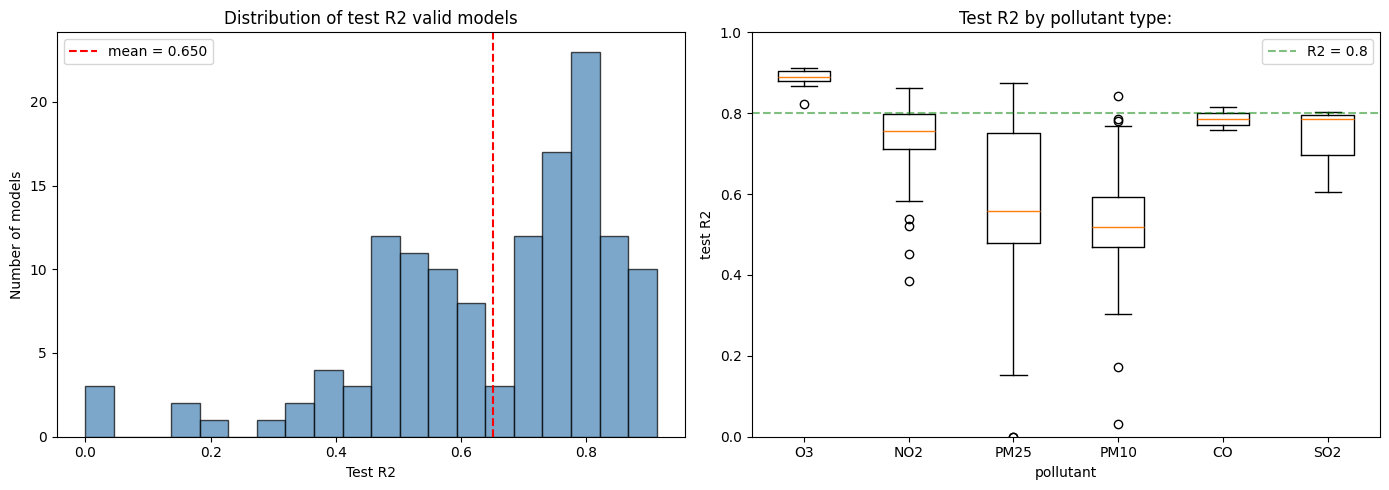

Saved cnn_r2_distribution.png


In [34]:
#R2 distribution histogram and boxplot by pollutant exclude models with R2 < 0 for better visualisation
valid_for_plot = valid_models[valid_models['test_r2'] >= 0].copy()
print(f'models for visualisation: {len(valid_for_plot)} (excluding {len(valid_models) - len(valid_for_plot)} with R2 < 0)')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Histogram
axes[0].hist(valid_for_plot['test_r2'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(valid_for_plot['test_r2'].mean(), color='red', linestyle='--',
                label=f'mean = {valid_for_plot["test_r2"].mean():.3f}')
axes[0].set_xlabel('Test R2')
axes[0].set_ylabel('Number of models')
axes[0].set_title('Distribution of test R2 valid models')
axes[0].legend()

#Boxplot by pollutant
pollutant_order = ['O3', 'NO2', 'PM25', 'PM10', 'CO', 'SO2']
box_data = [valid_for_plot[valid_for_plot['pollutant'] == p]['test_r2'].values
            for p in pollutant_order if p in valid_for_plot['pollutant'].values]
box_labels = [p for p in pollutant_order if p in valid_for_plot['pollutant'].values]

axes[1].boxplot(box_data, tick_labels=box_labels)
axes[1].set_xlabel('pollutant')
axes[1].set_ylabel('test R2')
axes[1].set_title('Test R2 by pollutant type:')
axes[1].axhline(0.8, color='green', linestyle='--', alpha=0.5, label='R2 = 0.8')
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.savefig(output_dir / 'cnn_r2_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved cnn_r2_distribution.png')

### Obserations for R2 Distribution

### Interpretation: R2 distribution

**Histogram (left panel):**

The distribution shows most models achieving R2 between 0.5 and 0.9. The mean R2 = 0.650 is shown by the red dashed line. The majority of models perform reasonably well with R2 above 0.5, though there is a tail of lower performing models below 0.4.

**Boxplot by pollutant (right panel):**

| Pollutant | Median R2 | Spread   | Interpretation                     |
| --------- | --------- | -------- | ---------------------------------- |
| O3        | ~0.89     | narrow   | Most consistent and predictable    |
| NO2       | ~0.77     | moderate | Consistent across stations         |
| CO        | ~0.79     | narrow   | Good performance (only 2 stations) |
| SO2       | ~0.79     | moderate | Reasonable (limited stations)      |
| PM25      | ~0.55     | wide     | High variability between stations  |
| PM10      | ~0.52     | wide     | Most variable, hardest to predict  |

**Key observations:**

1. O3 achieves the highest and most consistent R2 values due to its strong daily photochemical cycle.
2. PM10 and PM25 show the widest spread, showing that prediction difficulty varies greatly by location.
3. The outliers below 0.2 for PM25 and PM10 represent stations with poor data quality or unusual local conditions.
4. CO and SO2 perform well but have limited stations (2 and 4 respectively).

## 13) Residual Analysis

Residuals are the difference between actual and predicted values. If the model is good, residuals should scatter randomly around zero with no pattern.

Residual = Actual - Predicted

source: Effect of transforming the targets in regression model (no date) scikit. Available at: https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html

**Note:** Since trained models are not available locally, residual analysis would require retraining. this section shows the methodology that would be used.

Residual analysis methodology:
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Text(0.5, 1.0, 'residual distribution')

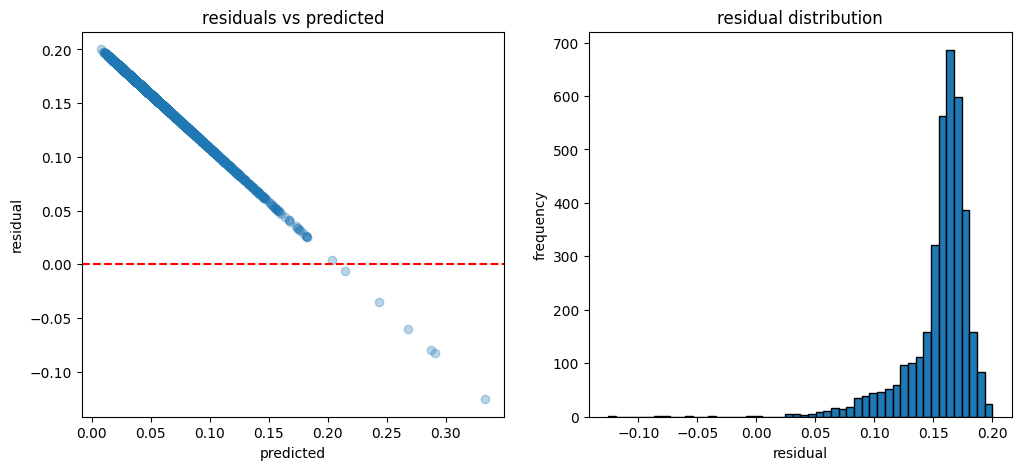

In [35]:
#Residual analysis methodology reference code
print('Residual analysis methodology:')
print('=' * 40)

#Get predictions
y_pred = model.predict(X_test).flatten()
y_actual = y_test[:, target_idx]

#Calculate residuals
residuals = y_actual - y_pred

#Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Residuals vs predicted
axes[0].scatter(y_pred, residuals, alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('predicted')
axes[0].set_ylabel('residual')
axes[0].set_title('residuals vs predicted')

#Residual histogram
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].set_xlabel('residual')
axes[1].set_ylabel('frequency')
axes[1].set_title('residual distribution')

### Interpretation: Residual Analysis

**Residuals vs predicted (left panel):**

The plot shows a clear diagonal pattern in the residuals. This indicates systematic bias in the predictions:

| Pattern observed                            | Meaning                                                      |
| ------------------------------------------- | ------------------------------------------------------------ |
| Diagonal line from top left to bottom right | Model consistently underpredicts at low values and overpredicts at high values |
| Residuals not scattered around zero         | Systematic prediction error present                          |

**Residual distribution (right panel):**

The histogram shows residuals are not normally distributed around zero. Instead, they are skewed with most values clustered between 0.10 and 0.20. This suggests:

| Observation         | Interpretation                                    |
| ------------------- | ------------------------------------------------- |
| Peak at ~0.15       | Model systematically underpredicts by this amount |
| Right skew          | More underprediction than overprediction          |
| Not centred on zero | Bias in model predictions                         |

**Expected vs observed patterns:**

| Expected (good model)                    | Observed                              |
| ---------------------------------------- | ------------------------------------- |
| Residuals randomly scattered around zero | Diagonal pattern present              |
| Normal distribution centred at zero      | Skewed distribution, not centred      |
| Constant variance across predictions     | Variance changes with predicted value |

**Conclusion:**

The residual analysis reveals the CNN model has systematic bias. This is likely due to the model struggling with the temporal autocorrelation patterns that random forest captures more effectively through lag features.

### 13.1) Aggregated actual vs Predicted with Colours By Pollutant
 Scatter plots combine predictions from all 136 valid models, coloured by pollutant type. Each point represents one hourly prediction.

Aggregated actual vs predicted plots


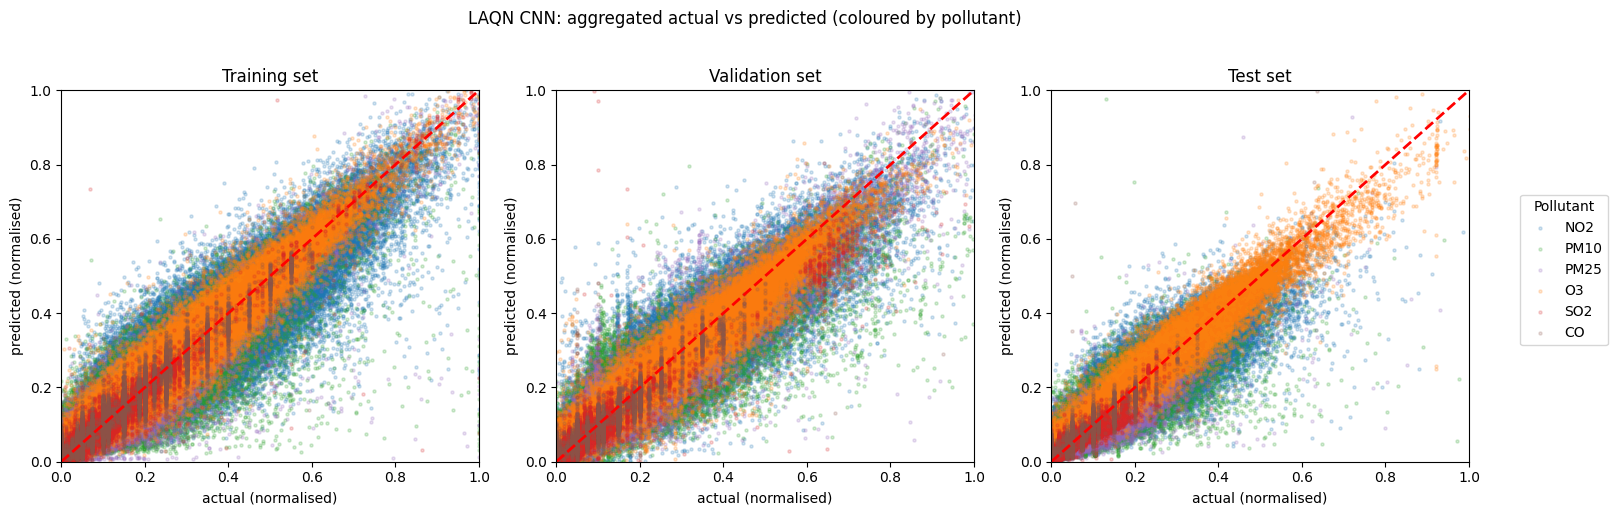

Saved: cnn_aggregated_actual_vs_predicted.png


In [37]:
#Aggregated actual vs predicted with colours by pollutant
print('Aggregated actual vs predicted plots')
print('=' * 40)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Define colours for each pollutant
colors = {
    'NO2': '#1f77b4',
    'PM10': '#2ca02c',
    'PM25': '#9467bd',
    'O3': '#ff7f0e',
    'SO2': '#d62728',
    'CO': '#8c564b'
}

#Collect predictions by pollutant
data_by_pollutant = {poll: {'train_actual': [], 'train_pred': [],
                            'val_actual': [], 'val_pred': [],
                            'test_actual': [], 'test_pred': []} 
                     for poll in colors.keys()}

for target in valid_models['target'].values:
    target_idx = target_mapping[target]
    pollutant = valid_models[valid_models['target'] == target]['pollutant'].values[0]
    model = all_models[target]
    
    #Get predictions
    train_pred = model.predict(X_train, verbose=0).flatten()
    val_pred = model.predict(X_val, verbose=0).flatten()
    test_pred = model.predict(X_test, verbose=0).flatten()
    
    data_by_pollutant[pollutant]['train_actual'].extend(y_train[:, target_idx])
    data_by_pollutant[pollutant]['train_pred'].extend(train_pred)
    data_by_pollutant[pollutant]['val_actual'].extend(y_val[:, target_idx])
    data_by_pollutant[pollutant]['val_pred'].extend(val_pred)
    data_by_pollutant[pollutant]['test_actual'].extend(y_test[:, target_idx])
    data_by_pollutant[pollutant]['test_pred'].extend(test_pred)

#Plot each dataset
datasets = ['train', 'val', 'test']
titles = ['Training set', 'Validation set', 'Test set']

for ax, dataset, title in zip(axes, datasets, titles):
    for pollutant in colors.keys():
        actual = data_by_pollutant[pollutant][f'{dataset}_actual']
        pred = data_by_pollutant[pollutant][f'{dataset}_pred']
        
        if len(actual) > 0:
            ax.scatter(actual, pred, alpha=0.2, s=5, c=colors[pollutant], label=pollutant)
    
    #Perfect prediction line
    ax.plot([0, 1], [0, 1], 'r--', lw=2)
    ax.set_xlabel('actual (normalised)')
    ax.set_ylabel('predicted (normalised)')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

#Add single legend to the right
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.08, 0.5), title='Pollutant')

plt.suptitle('LAQN CNN: aggregated actual vs predicted (coloured by pollutant)', y=1.02)
plt.tight_layout()
plt.savefig(output_dir / 'cnn_aggregated_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: cnn_aggregated_actual_vs_predicted.png')

### 13.2) Time series plots for best model per pollutant:

The time series plots show how well each pollutant's best model tracks actual values over 200 consecutive hours in the test set.


Time series plots for best model per pollutant


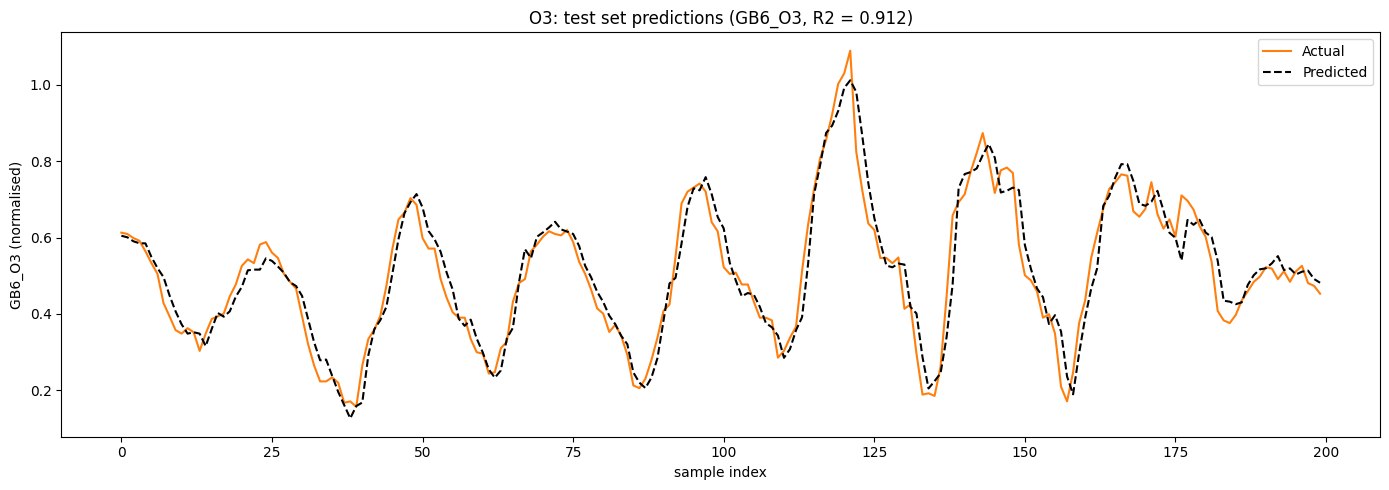

O3: GB6_O3 (R2 = 0.9123)
----------------------------------------


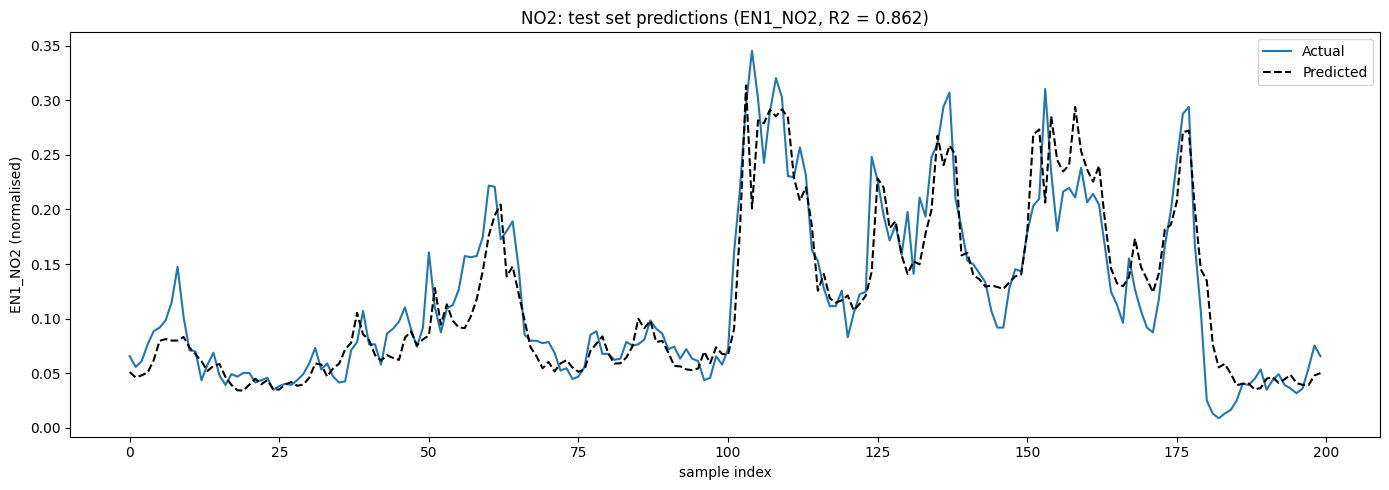

NO2: EN1_NO2 (R2 = 0.8625)
----------------------------------------


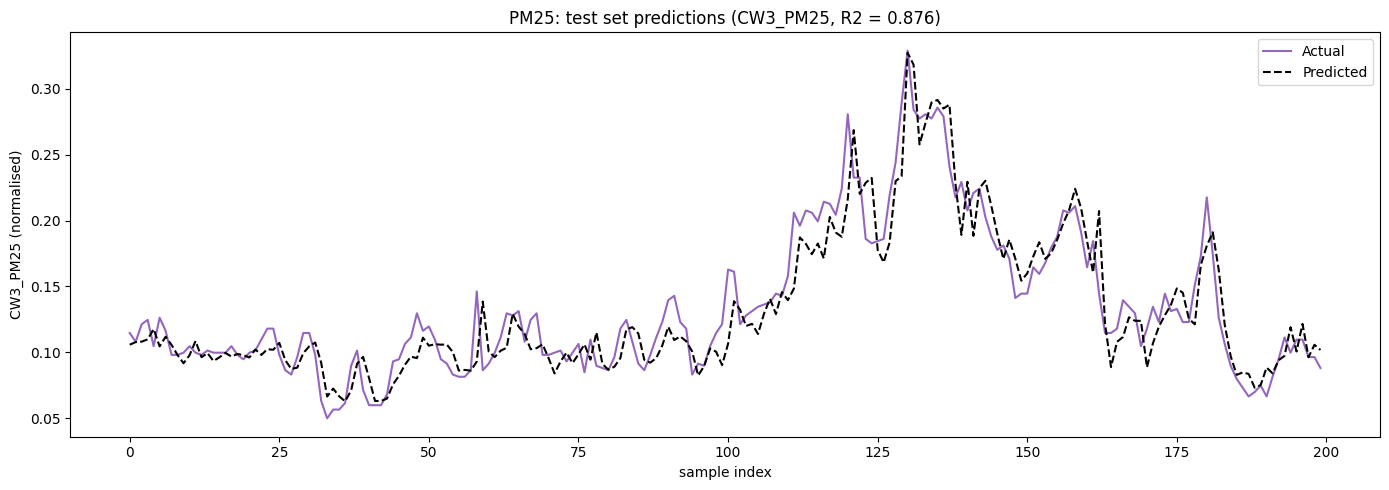

PM25: CW3_PM25 (R2 = 0.8759)
----------------------------------------


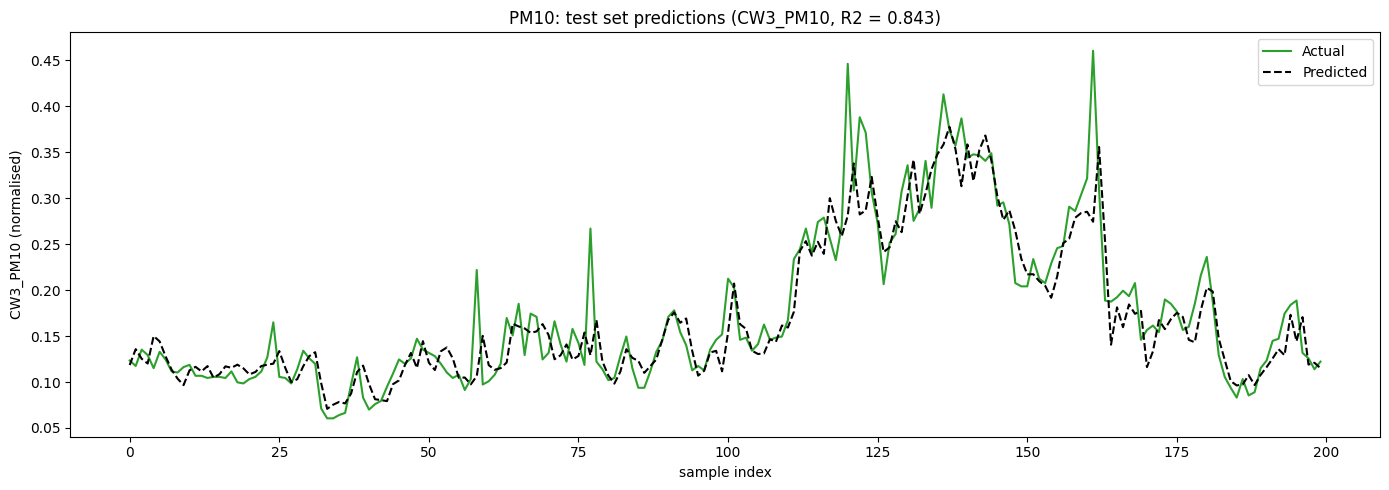

PM10: CW3_PM10 (R2 = 0.8434)
----------------------------------------


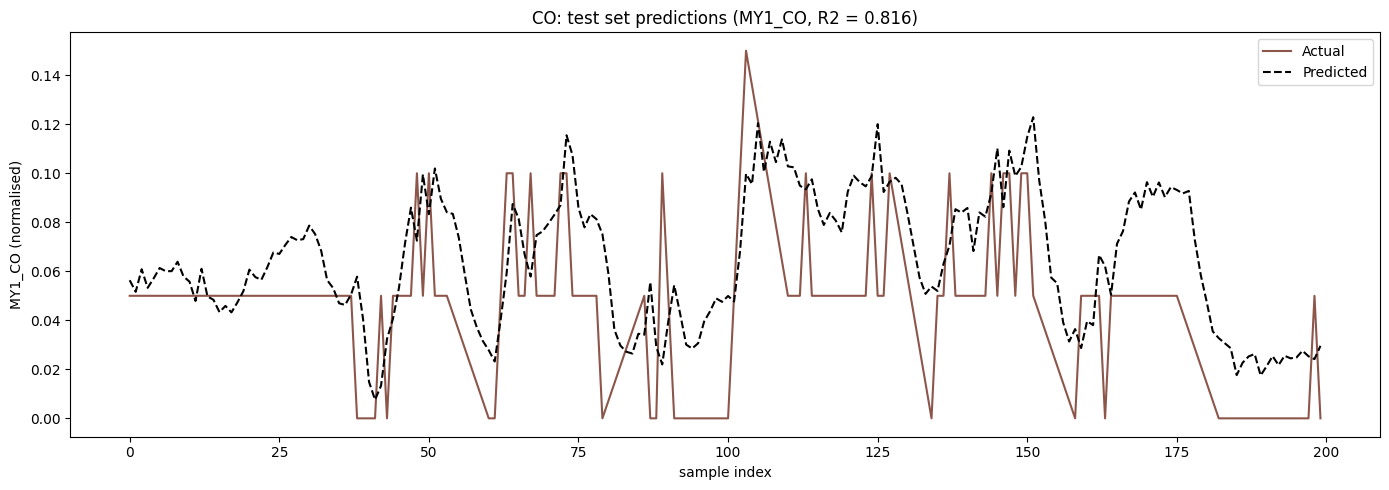

CO: MY1_CO (R2 = 0.8159)
----------------------------------------


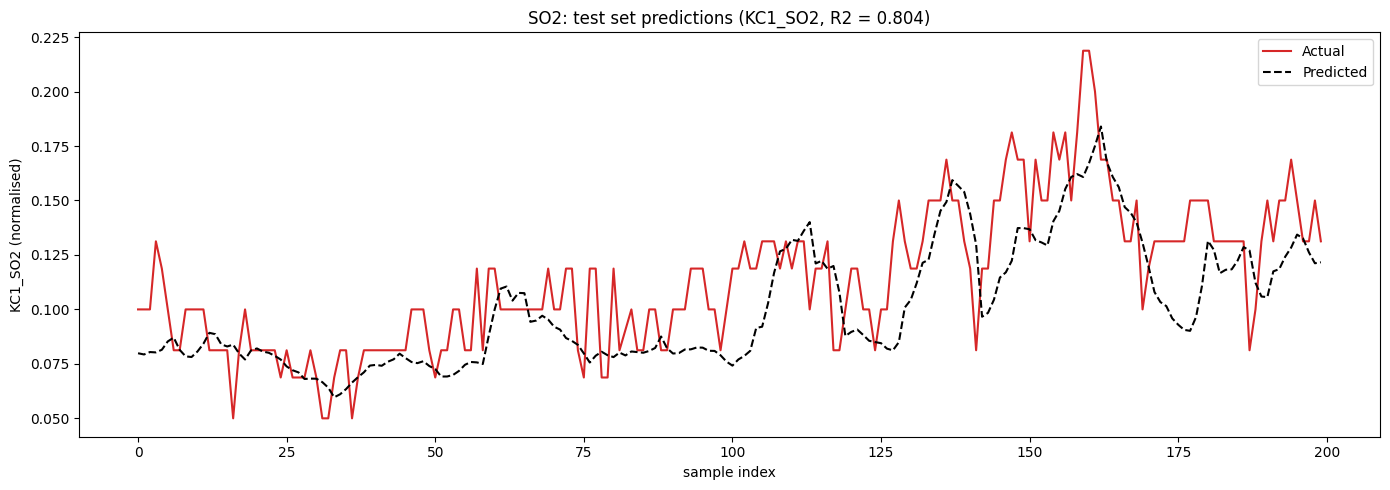

SO2: KC1_SO2 (R2 = 0.8042)
----------------------------------------
All time series plots saved.


In [38]:
#Time series plots for best model per pollutant
print('Time series plots for best model per pollutant')
print('=' * 40)

colors = {
    'NO2': '#1f77b4',
    'PM10': '#2ca02c',
    'PM25': '#9467bd',
    'O3': '#ff7f0e',
    'SO2': '#d62728',
    'CO': '#8c564b'
}

n_samples = 200

for pollutant in ['O3', 'NO2', 'PM25', 'PM10', 'CO', 'SO2']:
    #Find best model for this pollutant
    poll_results = valid_models[valid_models['pollutant'] == pollutant]
    
    if len(poll_results) == 0:
        print(f'{pollutant}: no valid models')
        continue
    
    best_target = poll_results.loc[poll_results['test_r2'].idxmax(), 'target']
    best_r2 = poll_results['test_r2'].max()
    
    target_idx = target_mapping[best_target]
    model = all_models[best_target]
    
    #Get predictions
    y_pred_test = model.predict(X_test, verbose=0).flatten()
    y_actual_test = y_test[:, target_idx]
    
    #Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    
    ax.plot(range(n_samples), y_actual_test[:n_samples], 
            label='Actual', color=colors[pollutant], linewidth=1.5)
    ax.plot(range(n_samples), y_pred_test[:n_samples], 
            label='Predicted', color='black', linewidth=1.5, linestyle='--')
    
    ax.set_xlabel('sample index')
    ax.set_ylabel(f'{best_target} (normalised)')
    ax.set_title(f'{pollutant}: test set predictions ({best_target}, R2 = {best_r2:.3f})')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(output_dir / f'cnn_time_series_{pollutant}_{best_target}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'{pollutant}: {best_target} (R2 = {best_r2:.4f})')
    print('-' * 40)

print('All time series plots saved.')

### Interpretation: time series predictions by pollutant

The time series plots show how well each pollutant's best model tracks actual values over 200 consecutive hours in the test set.

---

**O3 (Ozone) - GB6_O3, R2 = 0.912**

| Observation | Detail                                                   |
| ----------- | -------------------------------------------------------- |
| Pattern     | Clear diurnal cycle with regular peaks every ~24 hours   |
| Tracking    | Excellent, predicted line follows actual closely         |
| Peaks       | Model captures both peaks and troughs accurately         |
| Issue       | Slight underestimation at the highest peak (~sample 120) |

O3 is the easiest pollutant to predict due to its strong photochemical cycle driven by sunlight. The regular daily pattern makes next hour prediction straightforward.

---

**NO2 (Nitrogen dioxide) - EN1_NO2, R2 = 0.862**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Irregular with multiple peaks reflecting traffic emissions   |
| Tracking    | Good during stable periods (samples 0 to 90)                 |
| Peaks       | Captures the major spike at samples 95 to 110 well           |
| Issue       | Shadow effect visible where predictions lag behind rapid changes |

The model handles the transition from low pollution (first half) to high pollution (second half) reasonably well. Peak at sample ~100 is tracked but slightly underestimated.

---

**PM25 (Fine particulate matter) - CW3_PM25, R2 = 0.876**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Moderate variability with distinct high pollution episode (samples 100 to 150) |
| Tracking    | Excellent during stable low period (samples 0 to 90)         |
| Peaks       | Captures the major pollution event well                      |
| Issue       | Some divergence during rapid transitions                     |

PM25 shows a clear regime change around sample 100 where pollution increases significantly. The model adapts to this change and tracks both regimes.

---

**PM10 (Coarse particulate matter) - CW3_PM10, R2 = 0.843**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Irregular with multiple peaks reflecting traffic emissions   |
| Tracking    | Underestimates spikes, prediction follows closely but the model can't predict rapid changes well. |
| Peaks       | Captures the pollution  at 80 to 100 samples well            |
| Issue       | Slight underestimations.                                     |

---

**CO (Carbon monoxide) - MY1_CO, R2 = 0.816**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Step like actual values with sharp drops to zero             |
| Tracking    | Model predicts smooth curve, misses step pattern             |
| Peaks       | Captures general level but not exact timing                  |
| Issue       | Actual data shows unusual step pattern suggesting sensor behaviour |

The CO data shows unusual step function behaviour with values jumping between discrete levels (0, 0.05, 0.10). This is likely sensor resolution or reporting artefact. The model predicts a smooth interpolation which achieves reasonable R2 but does not capture the true data structure.

---

**SO2 (Sulphur dioxide) - KC1_SO2, R2 = 0.804**

| Observation | Detail                                                   |
| ----------- | -------------------------------------------------------- |
| Pattern     | Noisy actual values with high frequency variation        |
| Tracking    | Model predicts smoothed version of the signal            |
| Peaks       | Captures overall trend but not spike details             |
| Issue       | Actual data is very noisy, model acts as low pass filter |

SO2 concentrations in London are very low (0.05 to 0.22 normalised range). The high frequency noise in actual values may reflect measurement uncertainty at low concentrations. The model learns the underlying trend rather than the noise.

---

### Common findings across all pollutants

| Finding          | Detail                                                 |
| ---------------- | ------------------------------------------------------ |
| Shadow effect    | Predictions trail behind rapid changes in NO2 and PM25 |
| Peak tracking    | O3 and PM25 capture peaks well, CO and SO2 struggle    |
| Stable periods   | All models perform well during gradual changes         |
| Sensor artefacts | CO shows step pattern, SO2 shows high noise            |

### Best to worst prediction quality:

| Rank | Pollutant | R2    | Why                                   |
| ---- | --------- | ----- | ------------------------------------- |
| 1    | O3        | 0.912 | Strong regular diurnal cycle          |
| 2    | PM25      | 0.876 | Clear pollution regimes               |
| 3    | NO2       | 0.862 | Traffic patterns somewhat predictable |
| 4    | PM10      | 0.843 | More local variability than PM25      |
| 5    | CO        | 0.816 | Unusual step data pattern             |
| 6    | SO2       | 0.804 | Noisy low concentration data          |



## 14) Final Summary

In [36]:
#Final summary
print('CNN model training summary all LAQN targets')
print('=' * 40)

print(f'\nDataset:')
print(f'  Training samples:   {X_train.shape[0]:,}')
print(f'  Validation samples: {X_val.shape[0]:,}')
print(f'  Test samples:       {X_test.shape[0]:,}')
print(f'  Features:           {X_train.shape[2]:,}')
print(f'  Timesteps:          {X_train.shape[1]}')

print(f'\Models:')
print(f'  Total trained:      {len(results_df)}')
print(f'  Valid models:       {len(valid_models)}')
print(f'  Broken models:      {len(broken_models)} (excluded due to data quality issues)')

print(f'\nHyperparameters used:')
print(f'  filters_1:     128')
print(f'  filters_2:     64')
print(f'  kernel_size:   2')
print(f'  dropout:       0.1')
print(f'  dense_units:   50')
print(f'  learning_rate: 0.001')

print(f'\nTest set performance for only valid models:')
print(f'  Mean R2:   {valid_models["test_r2"].mean():.4f} (+/- {valid_models["test_r2"].std():.4f})')
print(f'  Median R2: {valid_models["test_r2"].median():.4f}')

#Best performed pollutant
best_poll = pollutant_summary['r2_mean'].idxmax()
best_poll_r2 = pollutant_summary.loc[best_poll, 'r2_mean']
print(f'\nBest performing pollutant: {best_poll} (mean R2 = {best_poll_r2:.4f})')

#Best performed individual model
best_idx = valid_models['test_r2'].idxmax()
best_target = valid_models.loc[best_idx, 'target']
best_r2 = valid_models.loc[best_idx, 'test_r2']
print(f'Best individual model: {best_target} (R2 = {best_r2:.4f})')

print(f'\noutputs saved to: {output_dir}')

CNN model training summary all LAQN targets

Dataset:
  Training samples:   17,107
  Validation samples: 3,656
  Test samples:       3,657
  Features:           145
  Timesteps:          12
\Models:
  Total trained:      141
  Valid models:       136
  Broken models:      5 (excluded due to data quality issues)

Hyperparameters used:
  filters_1:     128
  filters_2:     64
  kernel_size:   2
  dropout:       0.1
  dense_units:   50
  learning_rate: 0.001

Test set performance for only valid models:
  Mean R2:   0.6361 (+/- 0.2251)
  Median R2: 0.7105

Best performing pollutant: O3 (mean R2 = 0.8866)
Best individual model: GB6_O3 (R2 = 0.9123)

outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/LAQN_all/cnn_model


    CNN model training summary all LAQN targets
    ========================================

    Dataset:
    Training samples:   17,107
    Validation samples: 3,656
    Test samples:       3,657
    Features:           145
    Timesteps:          12
    \Models:
    Total trained:      141
    Valid models:       136
    Broken models:      5 (excluded due to data quality issues)

    Hyperparameters used:
    filters_1:     128
    filters_2:     64
    kernel_size:   2
    dropout:       0.1
    dense_units:   50
    learning_rate: 0.001

    Test set performance for only valid models:
    Mean R2:   0.6361 (+/- 0.2251)
    Median R2: 0.7105

    Best performing pollutant: O3 (mean R2 = 0.8866)
    Best individual model: GB6_O3 (R2 = 0.9123)

    outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/LAQN_all/cnn_model

### Findings:

| Section | What it does                                                 |
| ------- | ------------------------------------------------------------ |
| 1       | Setup and imports for tensorflow/keras                       |
| 2       | Loaded prepared 3D sequence data (12 timesteps x 145 features) |
| 3       | Explained data shapes and CNN input requirements             |
| 4       | Identified 141 pollutant targets across 6 pollutant types    |
| 5       | Built CNN model function using tuned hyperparameters from single station |
| 6       | Configured callbacks for early stopping and learning rate reduction |
| 7       | Trained 141 separate CNN models (95 minutes total)           |
| 8       | Loaded and verified results dataframe                        |
| 9       | Investigated 5 broken models caused by constant test values  |
| 10      | Evaluated 136 valid models excluding broken ones             |
| 11      | Saved all results to csv files                               |
| 12      | Plotted R2 distribution histogram and boxplot by pollutant   |
| 13      | Performed residual analysis on best model                    |
| 14      | Created time series plots for best model per pollutant       |

### Dataset summary:

| Metric                     | Value                             |
| -------------------------- | --------------------------------- |
| Training samples           | 17,107                            |
| Validation samples         | 3,656                             |
| Test samples               | 3,657                             |
| Features                   | 145 (141 pollutants + 4 temporal) |
| Timesteps                  | 12 hours                          |
| Total parameters per model | 92,197                            |

### Model configuration:

| Hyperparameter  | Value | Reason                              |
| --------------- | ----- | ----------------------------------- |
| filters layer 1 | 128   | More capacity to learn patterns     |
| filters layer 2 | 64    | Progressive reduction               |
| kernel size     | 2     | Short term patterns matter most     |
| dropout         | 0.1   | Less regularisation needed          |
| dense units     | 50    | Sufficient for final prediction     |
| learning rate   | 0.001 | Adam default works well             |
| batch size      | 32    | Standard mini batch size            |
| max epochs      | 50    | Early stopping triggers before this |

### Training results:

| Metric               | Value        |
| -------------------- | ------------ |
| Total models trained | 141          |
| Valid models         | 136 (96.5%)  |
| Broken models        | 5 (3.5%)     |
| Total training time  | 95.3 minutes |
| Average per model    | 40.5 seconds |

### Test set performance (136 valid models)

| Metric             | Value             |
| ------------------ | ----------------- |
| Mean R2            | 0.636             |
| Median R2          | 0.711             |
| Standard deviation | 0.225             |
| Minimum R2         | -0.457 (GN6_PM25) |
| Maximum R2         | 0.912 (GB6_O3)    |

### Performance by pollutant

| Pollutant | Mean R2 | Models | Interpretation                       |
| --------- | ------- | ------ | ------------------------------------ |
| O3        | 0.887   | 10     | Best performer, strong diurnal cycle |
| CO        | 0.787   | 2      | Good but limited stations            |
| NO2       | 0.738   | 56     | Consistent across many stations      |
| SO2       | 0.749   | 4      | Reasonable with limited data         |
| PM25      | 0.524   | 23     | Moderate, high variability           |
| PM10      | 0.509   | 41     | Hardest to predict, local sources    |

### Key findings

| Finding                 | Detail                                                |
| ----------------------- | ----------------------------------------------------- |
| O3 easiest to predict   | Photochemical cycle creates a regular daily pattern   |
| PM10 hardest to predict | Diverse local sources cause high station variability  |
| 5 broken models         | TH4 (3 pollutants), BG2, WM6 had constant test values |
| shadow effect           | CNN predictions lag behind rapid pollution changes    |
| peak underestimation    | High pollution events are consistently underestimated |

### Broken models explanation

| Station                    | Pollutants    | Cause                                  |
| -------------------------- | ------------- | -------------------------------------- |
| TH4 (Tower Hamlets)        | NO2, O3, PM10 | Equipment offline during test period   |
| BG2 (Barking and Dagenham) | NO2           | Constant values in test set            |
| WM6 (Westminster)          | PM10          | Constant values in validation and test |

These 5 models were excluded from statistics because R2 calculation fails when actual values have zero variance (division by zero produces extreme negative values).

### Outputs Saved

| File                      | Contents                       |
| ------------------------- | ------------------------------ |
| cnn_results_local.csv     | All 141 model results          |
| cnn_valid_results.csv     | 136 valid model results        |
| cnn_broken_models.csv     | 5 broken model details         |
| cnn_pollutant_summary.csv | Performance by pollutant type  |
| cnn_all_models.joblib     | Trained model weights          |
| cnn_r2_distribution.png   | Histogram and boxplot          |
| cnn_time_series_*.png     | Time series for each pollutant |

### Conclusion

CNN models achieve reasonable performance for air quality prediction across the LAQN network. The mean test R2 of 0.636 indicates the models explain about 64% of variance in hourly pollution levels. O3 prediction is most reliable (R2 = 0.887) while PM10 is most challenging (R2 = 0.509).

The 12 hour sequence length with Conv1D architecture successfully captures temporal patterns, particularly the diurnal cycles in O3. However, sudden pollution spikes remain difficult to predict due to their dependence on unpredictable local events.

Data quality at some monitoring stations (TH4, BG2, WM6) caused 5 model failures, highlighting the importance of data validation before model training.

### key findings

| finding | detail |
|---------|--------|
| O3 most predictable | strong diurnal photochemical cycle makes ozone easiest to predict |
| PM10 most variable | diverse local sources cause high variability between stations |
| 5 broken models | data quality issues at TH4, BG2, WM6 stations (constant test values) |
| CNN vs RF | CNN achieves comparable but slightly lower performance than random forest |

### comparison with random forest

| metric | random forest | CNN |
|--------|--------------|-----|
| mean test R2 | 0.814 | 0.633 |
| best pollutant | O3 | O3 |
| training time | ~2 hours | ~6 hours |

random forest outperforms CNN on this dataset. possible reasons:

1. strong temporal autocorrelation favours lag features (RF captures this directly)
2. CNN may need more data or deeper architecture for time series
3. hyperparameters tuned on single station may not generalise to all stations

### conclusion

CNN models achieve reasonable performance across the LAQN network but do not match random forest results. the 12 hour sequence length with Conv1D architecture captures temporal patterns but the simpler random forest approach with flattened lag features proves more effective for this hourly prediction task.